In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd

## Load forecast dataset into matrices.

In [2]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

# Read data.
data_path = './../mimic_iii_preprocessed.pkl'
data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

86902it [00:00, 822342.41it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [04:08<00:00,  9.55s/it]


In [3]:
len(rem_sub), fore_train_ip[1].shape, fore_valid_ip[0].shape

(15948, (421909, 880), (130714, 2))

In [4]:
# m = data.groupby('ts_ind').agg({'hour':'max'}).hour
# for q in [0.5,0.6,0.7,0.8,0.9, 0.95, 0.99, 1]:
#     print (q, m.quantile(q))
# import matplotlib.pyplot as plt
# plt.plot(sorted(list(m)))

## Load target dataset into matrices.

In [5]:
# Read data.
data_path = './../mimic_iii_preprocessed.pkl'
data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
# Filter labeled data in first 24h.
data = data.loc[data.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
data = data.loc[(data.hour>=0)&(data.hour<=24)]
oc = oc.loc[oc.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get y and N.
y = np.array(oc.sort_values(by='ts_ind')['in_hospital_mortality']).astype('float32')
N = data.ts_ind.max() + 1
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Trim to max len.
data = data.sample(frac=1)
data = data.groupby('ts_ind').head(880)
# Get N, V, var_to_ind.
N = data.ts_ind.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Add obs index.
data = data.sort_values(by=['ts_ind']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('ts_ind').agg({'obs_ind':'min'}).reset_index().rename(columns={ \
                                                            'obs_ind':'first_obs_ind'}), on='ts_ind')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']
# Find max_len.
max_len = data.obs_ind.max()+1
print ('max_len', max_len)
# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
values_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32')
for row in tqdm(data.itertuples()):
    ts_ind = row.ts_ind
    l = row.obs_ind
    times_inp[ts_ind, l] = row.hour
    values_inp[ts_ind, l] = row.value
    varis_inp[ts_ind, l] = row.vind
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)
# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
valid_ip = [ip[valid_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
test_ip = [ip[test_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
del times_inp, values_inp, varis_inp
train_op = y[train_ind]
valid_op = y[valid_ind]
test_op = y[test_ind]
del y

89624it [00:00, 762209.52it/s]


max_len 880


17468779it [00:27, 636033.09it/s]


In [6]:
y = np.concatenate((train_op,valid_op,test_op))
y.sum()/len(y)

0.11492457377488173

In [ ]:
# l = data.groupby('ts_ind').size()
# print (sorted(l)[-500:], l.quantile(0.99), len(l))

## Define metrics and losses.

In [7]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]
    
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define model architecture.

In [8]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = tf_utils.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

## Pretrain on forecasting.

In [9]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 880)]        0                                            
___________________________________________________________________________________________

  0%|                                                                                          | 0/3200 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2022-11-06 20:35:57.217636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-06 20:36:00.668752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro RTX 8000 major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000:3b:00.0
2022-11-06 20:36:00.669982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Quadro RTX 8000 major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000:5e:00.0
2022-11-06 20:36:00.671153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: Quadro RTX 8000 major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000:af:00.0
2022-11-06 20:36:00.672329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: Quadro RTX 8000 major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000:d8:00.0
2022-11-06 20:36:00.672578:

130714/130714 [==============================] - 105s 800us/sample - loss: 9.4982
Epoch 0 loss 11.521339502781629 val loss 9.49820749395281


0.293775: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:41<00:00,  9.38it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 9.4233 

130714/130714 [==============================] - 104s 792us/sample - loss: 8.6141
Epoch 1 loss 9.397938494384288 val loss 8.61412793928223


0.272637: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:40<00:00,  9.39it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 8.9605 

130714/130714 [==============================] - 103s 790us/sample - loss: 8.2323
Epoch 2 loss 8.721755356863142 val loss 8.232326513073104


0.263511: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:40<00:00,  9.39it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 8.5472 

130714/130714 [==============================] - 104s 794us/sample - loss: 8.0077
Epoch 3 loss 8.429789003506302 val loss 8.007674853005783


0.259029: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:48 - loss: 8.5293 

130714/130714 [==============================] - 103s 789us/sample - loss: 7.8055
Epoch 4 loss 8.286408933997155 val loss 7.805498668780764


0.252111: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:40<00:00,  9.39it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 8.5630 

130714/130714 [==============================] - 102s 784us/sample - loss: 7.5663
Epoch 5 loss 8.065105390548705 val loss 7.56633391919403


0.241777: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 8.3549 

130714/130714 [==============================] - 103s 789us/sample - loss: 7.5176
Epoch 6 loss 7.734512438625098 val loss 7.517591603936021


0.246859: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.45it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 8.2489 

130714/130714 [==============================] - 104s 793us/sample - loss: 7.4988
Epoch 7 loss 7.89709732465446 val loss 7.498829790283571


0.242240: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.9492 

130714/130714 [==============================] - 103s 785us/sample - loss: 7.3384
Epoch 8 loss 7.7493439324200155 val loss 7.3384169174207


0.244519: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.46it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.9111 

130714/130714 [==============================] - 103s 788us/sample - loss: 7.3625
Epoch 9 loss 7.8222547501325606 val loss 7.3624967166496385


0.240371: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.9424 

130714/130714 [==============================] - 104s 795us/sample - loss: 7.3040
Epoch 10 loss 7.689546133950353 val loss 7.304045297222662


0.234479: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.46it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.9328 

130714/130714 [==============================] - 104s 793us/sample - loss: 7.2049
Epoch 11 loss 7.501065139845013 val loss 7.2048564822178


0.236239: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:53 - loss: 8.7412 

130714/130714 [==============================] - 103s 790us/sample - loss: 7.5654
Epoch 12 loss 7.557375007420778 val loss 7.565445181694441


0.230722: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.7151 

130714/130714 [==============================] - 103s 789us/sample - loss: 7.2046
Epoch 13 loss 7.380873156636953 val loss 7.204648953952646


0.227410: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.7382 

130714/130714 [==============================] - 103s 788us/sample - loss: 7.1688
Epoch 14 loss 7.274931700155139 val loss 7.168828114157002


0.231743: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.6852 

130714/130714 [==============================] - 103s 787us/sample - loss: 7.0386
Epoch 15 loss 7.413527066856623 val loss 7.0385910169853965


0.226465: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.45it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.6499 

130714/130714 [==============================] - 103s 785us/sample - loss: 7.1059
Epoch 16 loss 7.244686341136694 val loss 7.105876587584029


0.228149: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.8976 

130714/130714 [==============================] - 103s 790us/sample - loss: 7.0417
Epoch 17 loss 7.29855405151844 val loss 7.041663353476379


0.228863: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.6673 

130714/130714 [==============================] - 103s 787us/sample - loss: 6.9996
Epoch 18 loss 7.3213922334462405 val loss 6.999618385563206


0.231413: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.4190

130714/130714 [==============================] - 104s 792us/sample - loss: 6.9867
Epoch 19 loss 7.40297484561801 val loss 6.98671518447253


0.225285: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.4873

130714/130714 [==============================] - 103s 789us/sample - loss: 6.9652
Epoch 20 loss 7.206924572438002 val loss 6.965218824405449


0.225058: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.6366 

130714/130714 [==============================] - 103s 788us/sample - loss: 6.9512
Epoch 21 loss 7.199683334454894 val loss 6.951232890461008


0.221680: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.3418

130714/130714 [==============================] - 103s 786us/sample - loss: 6.9695
Epoch 22 loss 7.091597516909242 val loss 6.969499421177693


0.226346: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.9217 

130714/130714 [==============================] - 103s 788us/sample - loss: 6.9409
Epoch 23 loss 7.240893275886774 val loss 6.940916955391696


0.222353: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.2472

130714/130714 [==============================] - 103s 788us/sample - loss: 6.8431
Epoch 24 loss 7.113132432848215 val loss 6.843078951106262


0.221526: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.4471

130714/130714 [==============================] - 103s 788us/sample - loss: 6.9772
Epoch 25 loss 7.0866992457211015 val loss 6.977194840561094


0.219658: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.45it/s]

    96/130714 [..............................] - ETA: 1:54 - loss: 7.5216 

130714/130714 [==============================] - 103s 785us/sample - loss: 6.8609
Epoch 26 loss 7.026940780133009 val loss 6.860922192973464


0.225724: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:48 - loss: 7.2309

130714/130714 [==============================] - 103s 784us/sample - loss: 6.7968
Epoch 27 loss 7.220996360033751 val loss 6.796751034807535


0.224280: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.4111

130714/130714 [==============================] - 103s 785us/sample - loss: 6.8511
Epoch 28 loss 7.174801443591714 val loss 6.85111950017529


0.222929: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.6106

130714/130714 [==============================] - 103s 789us/sample - loss: 6.8814
Epoch 29 loss 7.131565191075206 val loss 6.881413898902561


0.220573: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.6571 

130714/130714 [==============================] - 103s 791us/sample - loss: 6.9733
Epoch 30 loss 7.056189107000828 val loss 6.973291907664409


0.220885: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.3046

130714/130714 [==============================] - 103s 790us/sample - loss: 6.8438
Epoch 31 loss 7.0661883630603555 val loss 6.843793197195221


0.218270: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.3460

130714/130714 [==============================] - 103s 786us/sample - loss: 6.7257
Epoch 32 loss 6.982513721734286 val loss 6.72565069681523


0.218578: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.2980

130714/130714 [==============================] - 103s 787us/sample - loss: 6.8435
Epoch 33 loss 6.9923700650781395 val loss 6.843466281267071


0.217298: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:49 - loss: 7.0493

130714/130714 [==============================] - 103s 785us/sample - loss: 6.8237
Epoch 34 loss 6.951443980559707 val loss 6.823731822468637


0.219724: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.42it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.1687

130714/130714 [==============================] - 103s 788us/sample - loss: 6.7442
Epoch 35 loss 7.029023719504476 val loss 6.7442301494637436


0.219798: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.2726

130714/130714 [==============================] - 103s 786us/sample - loss: 6.6937
Epoch 36 loss 7.031399982497096 val loss 6.693660007217773


0.216904: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:52 - loss: 7.2559

130714/130714 [==============================] - 103s 788us/sample - loss: 6.7983
Epoch 37 loss 6.93882612593472 val loss 6.798263793126101


0.215454: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:39<00:00,  9.43it/s]

    96/130714 [..............................] - ETA: 1:51 - loss: 7.2562

130714/130714 [==============================] - 102s 784us/sample - loss: 6.9138
Epoch 38 loss 6.892449416294694 val loss 6.913782135411593


0.216464: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.45it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.1311

130714/130714 [==============================] - 103s 787us/sample - loss: 6.7664
Epoch 39 loss 6.9247444553673265 val loss 6.7663977827584345


0.215685: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.44it/s]

    96/130714 [..............................] - ETA: 1:44 - loss: 7.0467

130714/130714 [==============================] - 103s 785us/sample - loss: 6.6983
Epoch 40 loss 6.8998456051200625 val loss 6.698261646008421


0.219329: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.45it/s]

    96/130714 [..............................] - ETA: 1:48 - loss: 6.9850

130714/130714 [==============================] - 103s 788us/sample - loss: 6.7213
Epoch 41 loss 7.016408471763134 val loss 6.721296689205268


0.216868: 100%|█████████████████████████████████████████████████████████████████████| 3200/3200 [05:38<00:00,  9.46it/s]

    96/130714 [..............................] - ETA: 1:50 - loss: 7.2774

130714/130714 [==============================] - 103s 787us/sample - loss: 6.8128
Epoch 42 loss 6.93767501488328 val loss 6.812803515299831


## Train on different % of labeled data.

In [12]:
repeats = {k:10 for k in [10,20,30,40,50,60]}
lds = [10,20,30,40,50]
batch_size, lr, patience = 32, 0.0005, 10
d, N, he, dropout = 50,2,4,0.2
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'
f = open('log.csv', 'a+')
f.write('\nTraining on different % of labeled data\n')

train_inds = np.arange(len(train_op))
valid_inds = np.arange(len(valid_op))
gen_res = {}

np.random.seed(2021)
for ld in lds:
    np.random.shuffle(train_inds)
    np.random.shuffle(valid_inds)
    train_starts = [int(i) for i in np.linspace(0, len(train_inds)-int(ld*len(train_inds)/100), repeats[ld])]
    valid_starts = [int(i) for i in np.linspace(0, len(valid_inds)-int(ld*len(valid_inds)/100), repeats[ld])]
    f.write('Training on '+str(ld)+' % of labaled data+\n'+'val_metric,roc_auc,pr_auc,min_rp,savepath\n')
    all_test_res = []
    for i in range(repeats[ld]):
        print ('Repeat', i, 'ld', ld)
        # Get train and validation data.
        curr_train_ind = train_inds[np.arange(train_starts[i], train_starts[i]+int(ld*len(train_inds)/100))]
        curr_valid_ind = valid_inds[np.arange(valid_starts[i], valid_starts[i]+int(ld*len(valid_inds)/100))]
        curr_train_ip = [ip[curr_train_ind] for ip in train_ip]
        curr_valid_ip = [ip[curr_valid_ind] for ip in valid_ip]
        curr_train_op = train_op[curr_train_ind]
        curr_valid_op = valid_op[curr_valid_ind]
        print ('Num train:',len(curr_train_op),'Num valid:',len(curr_valid_op))
        # Construct save_path.
        savepath = 'new_mimic_iii_24hm_strats_no_interp_with_ss_repeat'+str(i)+'_'+str(ld)+'ld'+'.h5'
        print (savepath)
        # Build and compile model.
        model, fore_model =  build_strats(D, max_len, V, d, N, he, dropout, forecast=True)
        model.compile(loss=mortality_loss, optimizer=Adam(lr))
        fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
        # Load pretrained weights here.
        fore_model.load_weights(fore_savepath)
        # Train model.
        es = EarlyStopping(monitor='custom_metric', patience=patience, mode='max', 
                           restore_best_weights=True)
        cus = CustomCallback(validation_data=(curr_valid_ip, curr_valid_op), batch_size=batch_size)
        his = model.fit(curr_train_ip, curr_train_op, batch_size=batch_size, epochs=1000,
                        verbose=1, callbacks=[cus, es]).history
        model.save_weights(savepath)
        # Test and write to log.
        rocauc, prauc, minrp = get_res(test_op, model.predict(test_ip, verbose=0, batch_size=batch_size))
        f.write(str(np.min(his['custom_metric']))+str(rocauc)+str(prauc)+str(minrp)+savepath+'\n')
        print ('Test res', rocauc, prauc, minrp)
        all_test_res.append([rocauc, prauc, minrp])
        
    gen_res[ld] = []
    for i in range(len(all_test_res[0])):
        nums = [test_res[i] for test_res in all_test_res]
        gen_res[ld].append((np.mean(nums), np.std(nums)))
    print ('gen_res', gen_res)
f.close()

Repeat 0 ld 10
Num train: 2879 Num valid: 714
new_mimic_iii_24hm_strats_no_interp_with_ss_repeat0_10ld.h5
Train on 2879 samples
Epoch 1/1000
2879/2879 [==============================] - 13s 5ms/sample - loss: 0.5407
Epoch 2/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.4502
Epoch 3/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.4244
Epoch 4/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.3976
Epoch 5/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.3730
Epoch 6/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.3465
Epoch 7/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.3180
Epoch 8/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.2986
Epoch 9/1000
2879/2879 [==============================] - 10s 3ms/sample - loss: 0.2710
Epoch 10/1000
2879/2879 [==============================] - 10s 3ms/sample - loss

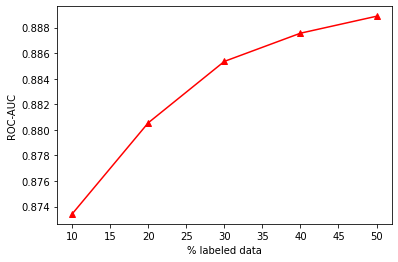

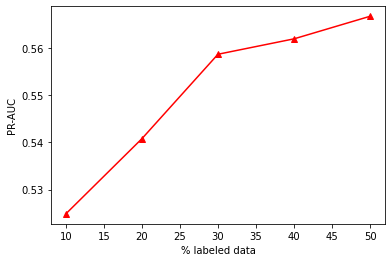

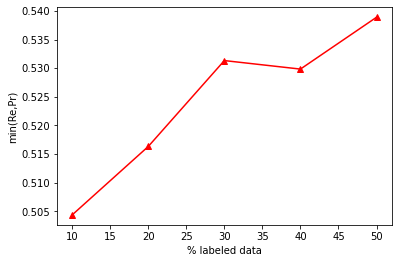

In [17]:
import matplotlib.pyplot as plt

x= range(10,51,10)
for i,metric in enumerate(['ROC-AUC', 'PR-AUC', 'min(Re,Pr)']):
    plt.figure()
    y = [gen_res[ld][i][0] for ld in x]
    plt.plot(x, y, color='r', marker='^')
    plt.xlabel('% labeled data')
    plt.ylabel(metric)